In [1]:
import os, sys
from pprint import pprint

sys.path.append('../')
import modules

In [2]:
# Load performance records

# find relevant perf logs:
perf_outputs = modules.utils.find_run_outputs('../perflogs', 'Gromacs', '.log')

# load them:
perf_records = []
for path in perf_outputs:
    records = modules.utils.read_perflog(path)
    perf_records.append(records)

print('loaded %s performance logs' % len(perf_records))

loaded 10 performance logs


{'hour_per_ns': {'ib-openmpi4-ucx': {1: 15.943,
                                     2: 8.135,
                                     4: 4.151,
                                     8: 2.192,
                                     16: 1.355},
                 'roce-openmpi4-ucx': {1: 15.843,
                                       2: 8.093,
                                       4: 4.194,
                                       8: 2.255,
                                       16: 1.623}},
 'ns_per_day': {'ib-openmpi4-ucx': {1: 1.505,
                                    2: 2.95,
                                    4: 5.781,
                                    8: 10.95,
                                    16: 17.713},
                'roce-openmpi4-ucx': {1: 1.515,
                                      2: 2.966,
                                      4: 5.722,
                                      8: 10.641,
                                      16: 14.787}}}


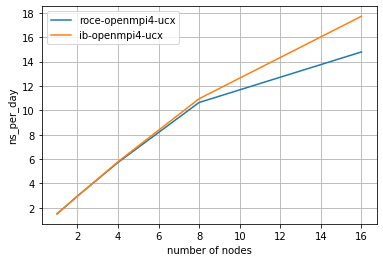

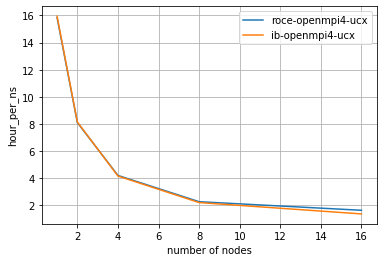

In [3]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt

# Plot comparisons across number of cores for most-recent tests:

# group performance data by testname - in this case this indicates number of nodes:
test_perf = modules.utils.group_by(perf_records, lambda x: x['meta']['testname'])

# now take slices ACROSS that - assumes any differences are the same for each number of nodes:
data = {} # data[perf_var][label][n_nodes] = last_value
for testname in test_perf:
    
    n_nodes = int(testname.split('_')[-1])
    cases = test_perf[testname]
    common, differences = modules.utils.diff_meta(cases)
    labels = []
    for unique_meta in differences:
        labels.append('-'.join(list(unique_meta.values())))
        
    for ix, c in enumerate(cases):
        for perf_var in c:
            if perf_var == 'meta':
                continue
            last_value = c[perf_var]['perf_value'][-1]
            
            
            label = labels[ix]
            
            if perf_var not in data:
                data[perf_var] = {}
            if label not in data[perf_var]:
                data[perf_var][label] = {}
            data[perf_var][label][n_nodes] = last_value
            
pprint(data)

for perf_var in data:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for label in data[perf_var]:
        xs = list(data[perf_var][label].keys())
        ys = list(data[perf_var][label].values())
    # now sort by number of cores:
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda xy: xy[0]))
        plt.plot(xs, ys, label=label)
#     #ax.set_title('%s: %s' % (test, perf_var))
    ax.legend()
    ax.grid()
    ax.set_xlabel('number of nodes')
    ax.set_ylabel(perf_var)
        

loaded 10 performance logs from 5 tests:
   Gromacs_SmallBM_1, Gromacs_SmallBM_2, Gromacs_SmallBM_8, Gromacs_SmallBM_16, Gromacs_SmallBM_4


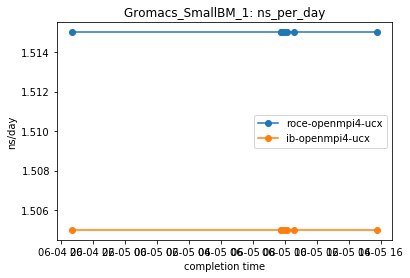

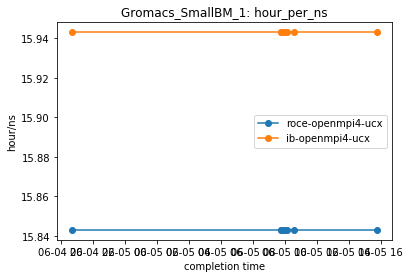

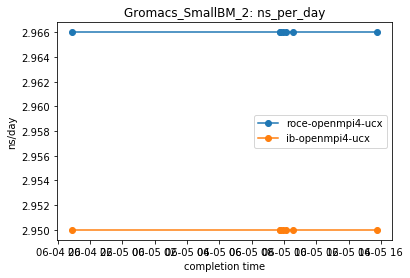

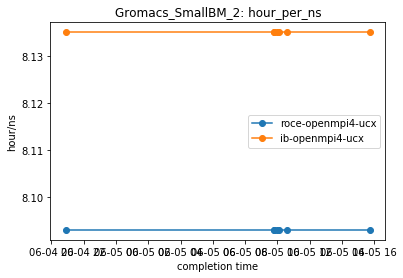

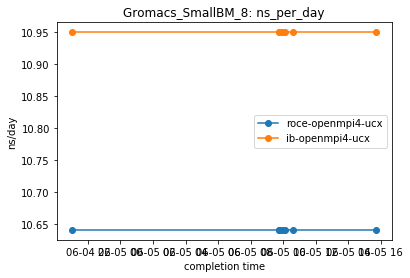

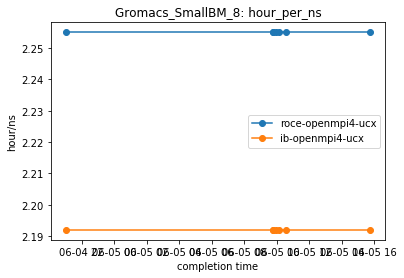

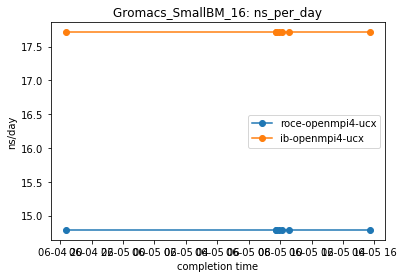

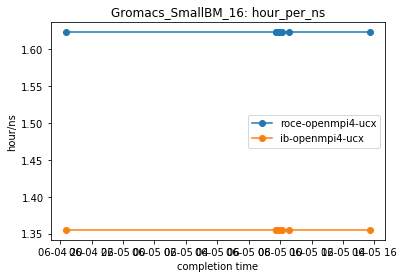

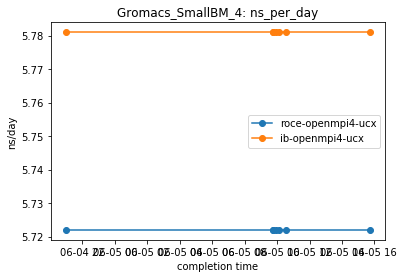

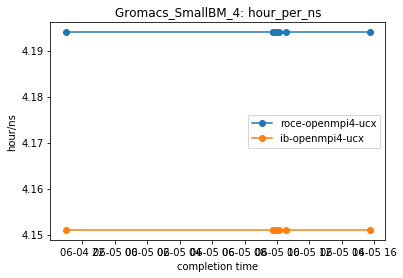

In [4]:
# Plot performance history - TODO: this could get moved to modules/ - e.g. IMB is the same
import datetime

from matplotlib.dates import date2num

print('loaded %s performance logs from %i tests:' % (len(perf_records), len(test_perf)))
print('  ', ', '.join(test_perf.keys()))


# plotting:
for test in test_perf:
    axes = {}
    cases = test_perf[test]
    common, differences = modules.utils.diff_meta(cases)
    for ix, case in enumerate(cases):
        
        unique_meta = differences[ix]
        for perf_var in case:
            if perf_var == 'meta': # not a real performance var
                continue
            
            # annoyingly can't use setdefault as this always evalutes `default`, so:
            if perf_var not in axes:
                axes[perf_var] = plt.subplots(nrows=1, ncols=1)
            fig, ax = axes[perf_var]           
            dates = case[perf_var]['completion_time']
            values = case[perf_var]['perf_value']
            label = '-'.join(list(unique_meta.values()))
            ax.plot_date(dates, values, 'o-', label=label)
            ax.set_title('%s: %s' % (test, perf_var))
            ax.legend()
            ax.grid()
            ax.set_xlabel('completion time')
            ax.set_ylabel(case[perf_var]['perf_unit'][0]) # shouldn't matter which unit is used
        